В данном ноутбуке представлен процесс тестирование и сравнение качества и производительности нескольких моделей для детекции лиц.

- Автор: Соловьева Екатерина
- GitHub Repository: https://github.com/qksolov/eyewear-counter



# Описание задачи

**Целью эксперимента** — выбор наиболее подходящей модели для последующего использования в задаче классификации типа очков на изображениях.

**Основные требования к модели**:

- Минимальное количество ложных срабатываний и пропущенных лиц,

- Быстрая скорость обработки (желательно с поддержкой batch-инференса и работы на GPU).

Для оценки моделей использовалась небольшая тестовая выборка, содержащая по 100 изображений на каждый из 3 классов (`glasses`, `plain`, `sunglasses`) . На каждом изображении присутствует ровно одно лицо.

В рамках этого теста не проводится полная оценка качества детекторов с использованием метрик вроде IoU и точной проверки корректности bounding box'ов.
Вместо этого используется упрощённый подход: на каждом изображении должно быть ровно одно лицо, и проверяется только количество детекций (одна, ноль или больше одной).

**Метрики**

Для каждой модели рассчитываются:

 - `num_detected` — количество изображений, на которых было корректно обнаружено ровно одно лицо,

- `false_positives` — общее количество лишних (некорректных) детекций на изображениях,

- `missed_faces` — количество изображений, на которых не было найдено ни одного лица,

- `avg_time_per_image` — среднее время обработки одного изображения.

# Setup

In [1]:
import os
import cv2
import numpy as np
import torch
import time
import pandas as pd

In [2]:
DATA_DIR = '/data/det_test'
CLASS_NAMES = ['glasses', 'plain', 'sunglasses']
IMG_SIZE = (512, 512)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
def load_images_from_folder(folder_path, img_size=IMG_SIZE):
    images_bgr = []
    images_rgb = []
    images_tensor = []
    filenames = []

    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        img = cv2.imread(file_path)
        if img is not None:
            img_resized_bgr = cv2.resize(img, img_size)                         # (H, W, C), np.uint8, BGR
            img_resized_rgb = cv2.cvtColor(img_resized_bgr, cv2.COLOR_BGR2RGB)  # (H, W, C), np.uint8, RGB

            img_resized_rgb_tensor = torch.from_numpy(img_resized_rgb).float() / 255.0
            img_resized_rgb_tensor = img_resized_rgb_tensor.permute(2, 0, 1)    # (C, H, W), float32, RGB

            images_bgr.append(img_resized_bgr)
            images_rgb.append(img_resized_rgb)
            images_tensor.append(img_resized_rgb_tensor)
            filenames.append(file_path)

    return np.stack(images_bgr), np.stack(images_rgb), torch.stack(images_tensor).to(device), filenames

def load_test_images(root_folder):
    data = {}

    for cls in CLASS_NAMES:
        cls_path = os.path.join(root_folder, cls)
        imgs_bgr, imgs_rgb, imgs_tensor, filenames = load_images_from_folder(cls_path)
        data[cls] = {
            'bgr': imgs_bgr,        # numpy array (N, H, W, 3), BGR
            'rgb': imgs_rgb,        # numpy array (N, H, W, 3), RGB
            'tensor': imgs_tensor,  # torch tensor (N, 3, H, W), RGB
            'filenames': filenames
        }
    return data

In [5]:
test_data = load_test_images(DATA_DIR)

print(test_data['glasses']['bgr'].shape)
print(test_data['plain']['rgb'].shape)
print(test_data['sunglasses']['tensor'].shape)

(100, 512, 512, 3)
(100, 512, 512, 3)
torch.Size([100, 3, 512, 512])


In [6]:
def evaluate_detector(detector_fn, test_data, model_name):
    results = []

    for cls in CLASS_NAMES:
        images = test_data[cls]

        start_time = time.time()
        counts = detector_fn(images) # list[число лиц найденых на фото]
        end_time = time.time()

        counts = np.array(counts)
        res_cls = {
            'model': model_name,
            'class': cls,
            'num_detected': int(np.sum(counts == 1)),
            'false_positives': int(np.sum(np.clip(counts - 1, 0, None))),
            'missed_faces': int(np.sum(counts == 0)),
            'time': end_time - start_time,
            'avg_time_per_image': (end_time - start_time) / len(counts)
        }
        results.append(res_cls)

    res_sum = {
        'model': model_name,
        'class': 'summary',
        'num_detected': sum(cls['num_detected'] for cls in results),
        'false_positives': sum(cls['false_positives'] for cls in results),
        'missed_faces': sum(cls['missed_faces'] for cls in results),
        'time': sum(cls['time'] for cls in results),
        'avg_time_per_image': float(np.mean([cls['avg_time_per_image'] for cls in results]))
    }
    results.append(res_sum)
    return pd.DataFrame(results)


In [37]:
results = []

# YuNet

In [ ]:
!wget https://github.com/opencv/opencv_zoo/raw/main/models/face_detection_yunet/face_detection_yunet_2023mar.onnx

In [8]:
yunet = cv2.FaceDetectorYN.create(
    model='face_detection_yunet_2023mar.onnx',
    config='',
    input_size=IMG_SIZE,
    score_threshold=0.68
)

In [9]:
def yunet_fn(images):
    counts = []
    for img in images['bgr']:
        _, faces = yunet.detect(img)
        if faces is None:
            counts.append(0)
        else:
            counts.append(len(faces))
    return counts

In [38]:
res = evaluate_detector(yunet_fn, test_data, 'YuNet')
res

,model,class,num_detected,false_positives,missed_faces,time,avg_time_per_image
0,YuNet,glasses,98,1,1,2.615987,0.026160
1,YuNet,plain,98,1,1,2.563317,0.025633
2,YuNet,sunglasses,96,2,2,2.215210,0.022152
3,YuNet,summary,292,4,4,7.394513,0.024648


In [39]:
results.append(res)

# RetinaFace

https://github.com/elliottzheng/batch-face

In [ ]:
!pip install -q batch-face

In [12]:
from batch_face import RetinaFace

batch_RF = RetinaFace(gpu_id=0)

In [13]:
def retinaface_fn(images):
    counts = []
    faces_batch = batch_RF(images['rgb'], threshold=0.5, batch_size=10)

    for faces in faces_batch:
        counts.append(len(faces))
    return counts

In [40]:
res = evaluate_detector(retinaface_fn, test_data, 'RetinaFace')
res

,model,class,num_detected,false_positives,missed_faces,time,avg_time_per_image
0,RetinaFace,glasses,96,1,3,0.435906,0.004359
1,RetinaFace,plain,100,0,0,0.442956,0.004430
2,RetinaFace,sunglasses,99,0,1,0.420385,0.004204
3,RetinaFace,summary,295,1,4,1.299248,0.004331


In [41]:
results.append(res)

# MTCNN

https://github.com/timesler/facenet-pytorch

In [21]:
!pip install -q facenet-pytorch

In [17]:
from facenet_pytorch import MTCNN

mtcnn = MTCNN(keep_all=True, device='cuda', thresholds=[0.7, 0.7, 0.7])

In [18]:
def mtcnn_fn(images):
    counts = []
    faces_batch, _ = mtcnn.detect(images['rgb'])

    for faces in faces_batch:
        if faces is None:
            counts.append(0)
        else:
            counts.append(len(faces))
    return counts

In [42]:
res = evaluate_detector(mtcnn_fn, test_data, 'MTCNN')
res

,model,class,num_detected,false_positives,missed_faces,time,avg_time_per_image
0,MTCNN,glasses,96,4,1,1.023290,0.010233
1,MTCNN,plain,94,3,3,0.922708,0.009227
2,MTCNN,sunglasses,93,5,3,1.001329,0.010013
3,MTCNN,summary,283,12,7,2.947327,0.009824


In [43]:
results.append(res)

# YOLO

In [ ]:
!pip install -q ultralytics

In [ ]:
!wget https://github.com/akanametov/yolo-face/releases/download/v0.0.0/yolov11n-face.pt

In [ ]:
from ultralytics import YOLO

yolo = YOLO('yolov11n-face.pt')
yolo.to('cuda')
yolo.eval()

In [29]:
def yolo_fn(images):
    with torch.no_grad():
        counts = []
        faces_batch = yolo.predict(images['tensor'], conf=0.7, verbose=False)
        for faces in faces_batch:
            if faces.boxes is None:
                counts.append(0)
            else:
                counts.append(len(faces.boxes.xyxy))
        return counts

In [44]:
res = evaluate_detector(yolo_fn, test_data, 'YOLO')
res

,model,class,num_detected,false_positives,missed_faces,time,avg_time_per_image
0,YOLO,glasses,97,2,1,0.408737,0.004087
1,YOLO,plain,99,0,1,0.359811,0.003598
2,YOLO,sunglasses,99,0,1,0.356084,0.003561
3,YOLO,summary,295,2,3,1.124633,0.003749


In [45]:
results.append(res)

# Сравнение моделей

In [46]:
df = pd.concat(results, ignore_index=True)

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

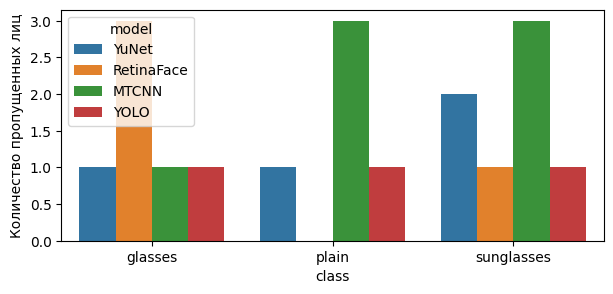

In [74]:
plt.figure(figsize=(7, 3))
sns.barplot(df[df['class'] != 'summary'], x="class", y="missed_faces", hue="model")
plt.ylabel("Количество пропущенных лиц")
plt.show()

In [77]:
df_summary = df[df["class"] == "summary"]
df_summary[["model", "num_detected", "false_positives", "missed_faces", "avg_time_per_image"]]

,model,num_detected,false_positives,missed_faces,avg_time_per_image
3,YuNet,292,4,4,0.024648
7,RetinaFace,295,1,4,0.004331
11,MTCNN,283,12,7,0.009824
15,YOLO,295,2,3,0.003749


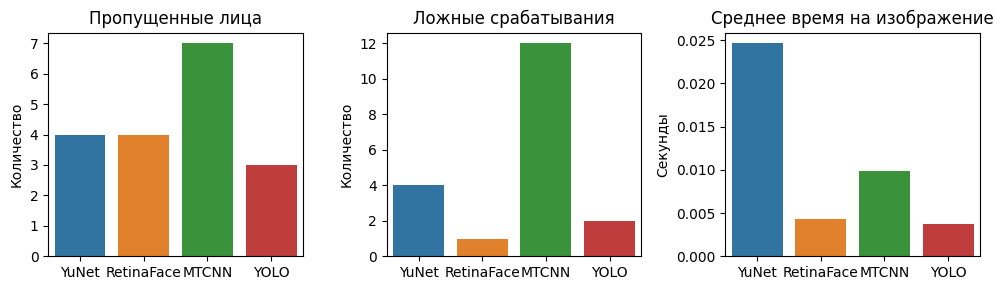

In [82]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharex=False)

sns.barplot(data=df_summary, x="model", y="missed_faces", ax=axes[0], hue="model")
axes[0].set_title("Пропущенные лица")
axes[0].set_ylabel("Количество")
axes[0].set_xlabel("")

sns.barplot(data=df_summary, x="model", y="false_positives", ax=axes[1], hue="model")
axes[1].set_title("Ложные срабатывания")
axes[1].set_ylabel("Количество")
axes[1].set_xlabel("")

sns.barplot(data=df_summary, x="model", y="avg_time_per_image", ax=axes[2], hue="model")
axes[2].set_title("Среднее время на изображение")
axes[2].set_ylabel("Секунды")
axes[2].set_xlabel("")


plt.tight_layout()
plt.show()

# Вывод
На данной небольшой выборке **YOLO** и **RetinaFace** показали лучшие результаты как по точности, так и по скорости обработки, поэтому были выбраны для дальнейшего использования в проекте:

- **YOLO** использована в качестве основной модели: она обеспечила наименьшее количество ошибок и наивысшую скорость. Дополнительное преимущество — возможность полной работы на GPU без необходимости копирования результатов на CPU.

- **RetinaFace** также показала высокое качество и хорошую скорость, поэтому может быть выбрана в качестве альтернативной модели. Её недостаток — текущая реализация возвращает результаты в виде NumPy-массивов, что требует дополнительной передачи данных с CPU обратно на GPU для дальнейшего использования.

- **MTCNN** немного уступает по скорости, но могла бы рассматриваться как вариант, если бы не большое количество ложных срабатываний и пропусков лиц.

- **YuNet** была единственной моделью из рассмотренных без поддержки batch обработки, что и объясняет её заметно более длительное время работы. Несмотря на неплохое качество детекции, долгое время обработки делает её непригодной для данного проекта.